## Machine Learning Workflow Part 3

In this project, we are walking through a complete machine learning problem dealing with a real-world dataset. Using building energy data, we are trying to build a model to predict the Energy Star Score of a building, making this a supervised regression, machine learning task.

In the first two parts of this project, we implemented the first 6 steps of the machine learning pipeline:

* Data cleaning and formatting
* Exploratory data analysis
* Feature engineering and selection
* Compare several machine learning models on a performance metric
* Perform hyperparameter tuning on the best model to optimize it for the problem
* Evaluate the best model on the testing set
* Interpret the model results to the extent possible
* Draw conclusions and write a well-documented report

In this notebook, we will concentrate on the last two steps, and try to peer into the black box of the model we built. We know is it accurate, as it can predict the Energy Star Score to within 9.1 points of the true value, but how exactly does it make predictions? We'll examine some ways to attempt to understand the gradient boosting machine and then draw conclusions (I'll save you from having to write the report and instead link to the report I completed for the company who gave me this assignment as a job screen.)

### Importing libraries

In [3]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

### Read the Data

In [6]:
# Read in data into dataframes 
train_features = pd.read_csv('../datasets/data/training_features.csv')
test_features = pd.read_csv('../datasets/data/testing_features.csv')
train_labels = pd.read_csv('../datasets/data/training_labels.csv')
test_labels = pd.read_csv('../datasets/data/testing_labels.csv')

### Recreate final model

In [7]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [8]:
# function to create mean absolute error
def mae(y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

In [9]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=101)
model.fit(X,y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=101, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0644


## Interprete the Model
Machine learning is often criticized as being a black-box: we put data in on one side and it gives us the answers on the other. While these answers are often extremely accurate, the model tells us nothing about how it actually made the predictions. This is true to some extent, but there are ways in which we can try and discover how a model "thinks" such as the Locally Interpretable Model-agnostic Explainer (LIME). This attemps to explain model predictions by learning a linear regression around the prediction, which is an easily interpretable model!

We will explore several ways to interpret our model:

* Feature importances
* Locally Interpretable Model-agnostic Explainer (LIME)
* Examining a single decision tree in the ensemble.

## Feature Importances
One of the basic ways we can interpret an ensemble of decision trees is through what are known as the feature importances. These can be interpreted as the variables which are most predictive of the target. While the actual details of the feature importances are quite complex, we can use the relative values to compare the features and determine which are most relevant to our problem.

Extracting the feature importances from a trained ensemble of trees is quite easy in scikit-learn. We will store the feature importances in a dataframe to analyze and visualize them.

In [11]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.508177
1,Weather Normalized Site Electricity Intensity ...,0.179006
2,Property Id,0.033844
3,Water Intensity (All Water Sources) (gal/ft²),0.032307
4,log_Water Intensity (All Water Sources) (gal/ft²),0.031968
5,Largest Property Use Type_Non-Refrigerated War...,0.031702
6,Year Built,0.024462
7,DOF Gross Floor Area,0.024180
8,Largest Property Use Type_Multifamily Housing,0.022390
9,log_Direct GHG Emissions (Metric Tons CO2e),0.022267


The Site Energy Use Intensity, Site EUI (kBtu/ft²), and the Weather Normalized Site Electricity Intensity, Weather Normalized Site Electricity Intensity (kWh/ft²) are the two most important features by quite a large margin. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

Let's graph the feature importances to compare visually.

Text(0.5, 1.0, 'Feature Importances from Random Forest')

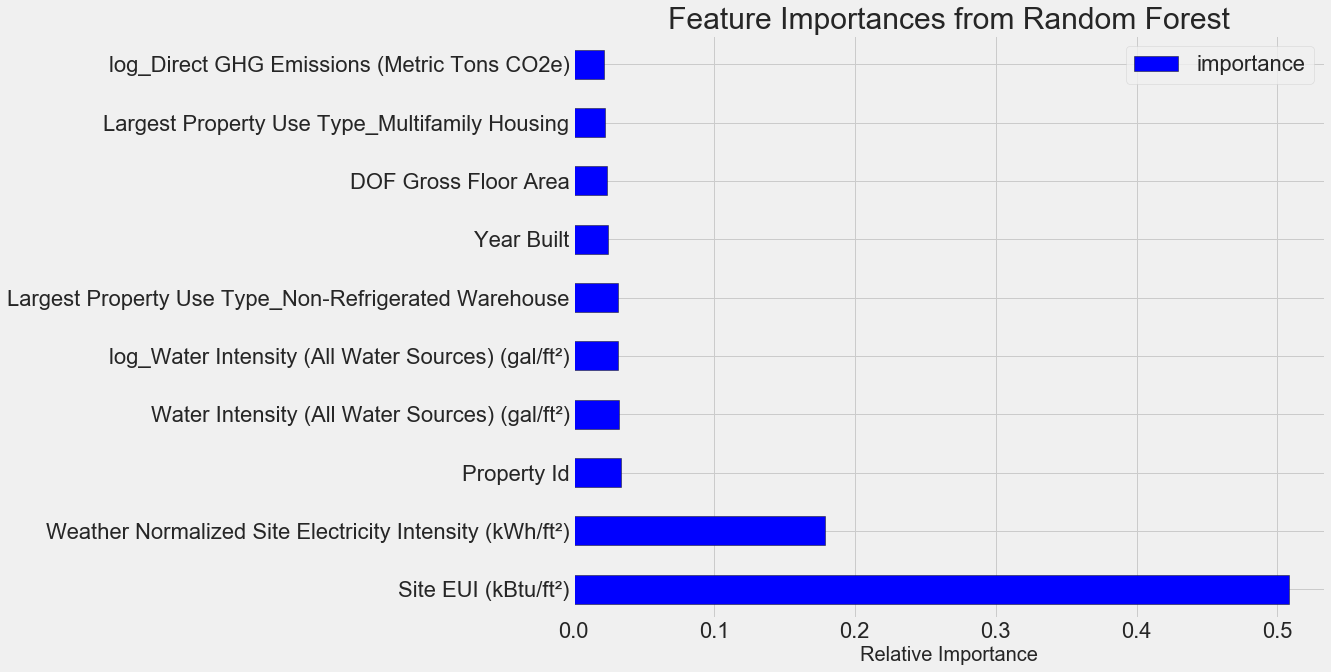

In [12]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue')
plt.xlabel('Relative Importance', size = 20)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30)

## Use Feature Importances for Feature Selection
Given that not every feature is important for finding the score, what would happen if we used a simpler model, such as a linear regression, with the subset of most important features from the random forest? The linear regression did outperform the baseline, but it did not perform well compared to the model complex models. Let's try using only the 10 most important features in the linear regression to see if performance is improved. We can also limit to these features and re-evaluate the random forest.

In [13]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [14]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4651.
Linear Regression Reduced Results: MAE = 14.4016.


Well, reducing the features did not improve the linear regression results! It turns out that the extra information in the features with low importance do actually improve performance.

***Let's look at using the reduced set of features in the gradient boosted regressor. How is the performance affected?***

In [15]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.4863


** The model results are slightly worse with the reduced set of features and we will keep all of the features for the final model. The desire to reduce the number of features is because we are always looking to build the most parsimonious model: that is, the simplest model with adequate performance. A model that uses fewer features will be faster to train and generally easier to interpret. In this case, keeping all of the features is not a major concern because the training time is not significant and we can still make interpretations with many features. **

### Locally Interpretable Model-agnostic Explanations
We will look at using LIME to explain individual predictions made the by the model. LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

We will look at trying to explain the predictions on an example the model gets very wrong and an example the model gets correct. We will restrict ourselves to using the reduced set of 10 features to aid interpretability. The model trained on the 10 most important features is slightly less accurate, but we generally have to trade off accuracy for interpretability!

In [16]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [17]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 11.7877
Actual Value: 96.0000


Text(0.5, 0, 'Effect on Prediction')

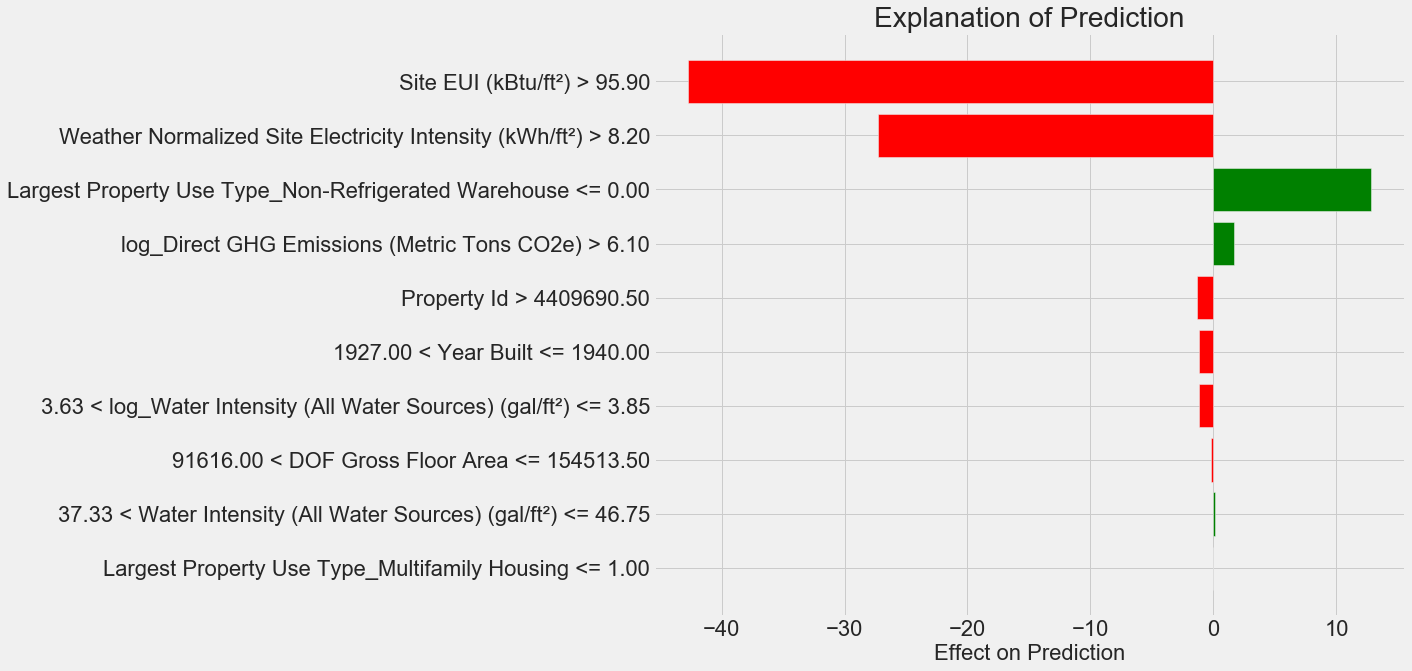

In [18]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

In this example, our gradient boosted model predicted a score of 11.78 and the actual value was 96.

The plot from LIME is showing us the contribution to the final prediction from each of the features for the example. We can see that the Site EUI singificantly decreased the prediction because it was above 95.90. The Weather Normalized Site Electricity Intensity on the other hand, increased the prediction because it was lower than 8.20.

We can interpret this as saying that our model thought the Energy Star Score would be much lower than it actually was because the Site EUI was high. However, in this case, the score was 96 despite the high value of the EUI. While this significant mistake (off by 85 points!) might initially have been confusing, now we can see that in reality, the model was reasoning through the problem and just arrived at the incorrect value! A human going over the same process probably would have arrived at the same conclusion (if they had the patience to go through all the data).

*** Now we can go through the same process with a prediction the model got correct. ***

Prediction: 100.0000
Actual Value: 100.0000


Text(0.5, 0, 'Effect on Prediction')

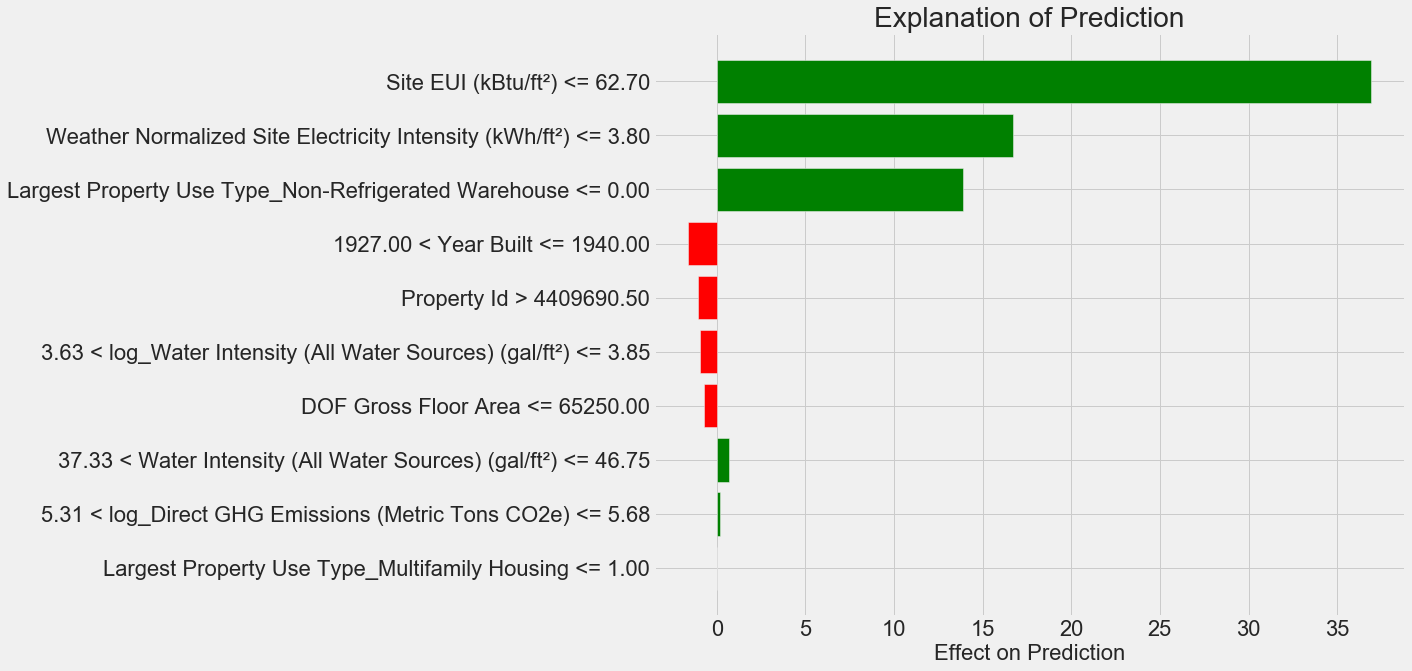

In [19]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

In [20]:
right_exp.show_in_notebook(show_predicted_value=False)

The correct value for this case was 100 which our gradient boosted model got right on!

The plot from LIME again shows the contribution to the prediciton of each of feature variables for the example. For instance, because the Site EUI was less than 62.70, that contributed significantly to a higher estimate of the score. Likewise, the year built being less than 1927 also positively contributed to the final prediction.

Observing break down plots like these allow us to get an idea of how the model makes a prediction. This is probably most valuable for cases where the model is off by a large amount as we can inspect the errors and perhaps engineer better features or adjust the hyperparameters of the model to improve predictions for next time. The examples where the model is off the most could also be interesting edge cases to look at manually. The model drastically underestimated the Energy Star Score for the first building because of the elevated Site EUI. We might therefore want to ask why the building has such a high Energy Star Score even though it has such a high EUI. A process such as this where we try to work with the machine learning algorithm to gain understanding of a problem seems much better than simply letting the model make predictions and completely trusting them! Although LIME is not perfect, it represents a step in the right direction towards explaining machine learning models.

## Examining a Single Decision Tree

One of the coolest parts about a tree-based ensemble is that we can look at any individual estimator. Although our final model is composed of 800 decision trees, and looking at a single one is not indicative of the entire model, it still allows us to see the general idea of how a decision tree works. From there, it is a natural extension to imagine hundreds of these trees building off the mistakes of previous trees to make a final prediction (this is a significant oversimplification of how gradient boosting regression works!)

We will first extract a tree from the forest and then save it using sklearn.tree.export_graphviz. This saves the tree as a .dot file which can be converted to a png using command line instructions in the Notebook.


In [24]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = '../assets/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x12A3F4490,
                      splitter='best')

In [ ]:
# Convert to a png from the command line
# This requires the graphviz visualization library (https://www.graphviz.org/)


# !dot -Tpng images/tree.dot -o images/tree.png

In [25]:
tree.export_graphviz(single_tree, out_file = '../assets/tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

## Make Conclusions and Document Findings
The final part of the machine learning pipeline might be the most important: we need to compress everything we have learned into a short summary highlighting only the most crucial findings. Personally, I have difficulty avoiding explaining all the technical details because I enjoy all the work. However, the person you're presenting to probably doesn't have much time to listen to all the details and just wants to hear the takeaways. Learning to extract the most important elements of data science or machine learning project is a crucial skill, because if our results aren't understood by others, then they will never be used!

I encourage you to come up with your own set of conclusions, but here are my top 2 designed to be communicated in 30 seconds:

* Using the given building energy data, a machine learning model can predict the Energy Star Score of a building to within 10 points.
* The most important variables for determining the Energy Star Score are the Energy Use Intensity, Electricity Use Intensity, and the Water Use Intensity

If anyone asks for the details, then we can easily explain all the implementation steps, and present our (hopefully) well-documented work. Another crucial aspect of a machine learning project is that you have commented all your code and made it easy to follow! You want someone else (or yourself in a few months) to be able to look at your work and completely understand the decisions you made. Ideally you should write code with the intention that it will be used again. Even when we are doing projects by ourselves, it's good to practice proper documentation and it will make your life much easier when you want to revisit a project.

## Presenting your Work
One of the best aspects about Jupyter Notebooks is that they can be directly downloaded as a pdf or html and then shared with others. 

With that in mind, I think it's time for us to wrap up this project! I had a great time writing these notebooks and doing the analysis, and I hope you enjoyed reading this and now feel more confident in implementing your own machine learning project. If you want, you can start by modifying this project and trying to beat my models! Remember, don't feel like you have to go it alone: there are plenty of amazing machine learning resources out there, and coming from someone who is entirely self-taught thanks to the great data science community, the best way to learn is to get involved and start putting your work out there!

Use ** jupyter nbconvert ../Code/Day47-MLWorkflowPart3.ipynb **
this command to convert jupyter notebook file to html file and then convert html file to pdf using any online converter.